In [1]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

E:\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import random
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [5]:
file_loc='../../ADNI_data/future_dx_prediction_alz_plos/'
# df_all = pd.read_csv('step5_modified_mri_alz_future_prediction_plos.csv')
df_all_step3 = pd.read_csv(file_loc + 'df_step3_addedmri_dep_fl.csv')
df_all = pd.read_csv(file_loc + 'step5_modified_all_mri_imageidna_drop_alz_future_prediction_plos.csv')
df_all.shape

(3390, 32)

In [6]:
df_all_step3.columns

Index(['RID', 'COLPROT', 'ORIGPROT', 'PTID', 'SITE', 'VISCODE', 'EXAMDATE',
       'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Years_bl', 'Month_bl', 'Month',
       'M', 'update_stamp', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'CDRSB', 'FAQ', 'EcogPtMem',
       'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan',
       'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting',
       'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'MOCA', 'mPACCdigit',
       'mPACCtrailsB', 'ABETA', 'TAU', 'PTAU', 'FDG', 'PIB', 'AV45',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'FMonth_0', 'FMonth_1', 'FMonth_2', 'FMonth_3',
       'FMonth_4', 'FMonth_5', 'FDX_0', 'FDX_1', 'FDX_2', 'FDX_3',

In [7]:
df_pre_result = pd.read_csv('cm_list_fullmri_RNN_1d_1_full.csv')
rdseed_pre_list = df_pre_result['rdseed_pre_list'].tolist()

In [8]:
df_all = df_all.merge(df_all_step3[['RID','AGE','MMSE']])
df_all.shape

(3381, 34)

In [9]:
df_all['age_norm'] = (df_all['AGE']-df_all['AGE'].mean())/df_all['AGE'].std()
df_all['MMSE_norm'] = (df_all['MMSE']-df_all['MMSE'].mean())/df_all['MMSE'].std()

In [10]:
# df_all_step3.columns

In [11]:
feature_col_addmri=    [ 'RightParahippocampal', 'RightInferiorTemporal',
       'RightInferiorParietal', 'RightIsthmusCingulate', 'RightBankssts',
       'RightPrecuneus', 'RightAmygdala', 'RightAccumbensArea',
       'RightMedialOrbitofrontal', 'RightPallidum', 'RightCaudalMiddleFrontal',
       'RightPutamen', 'RightRostralAnteriorCingulate', 'RightParacentral',
       'RightPrecentral', 'RightLingual' ]
feature_target_col = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform','MidTemp', 'ICV','FollowupDX']
feature_target_col = ['MMSE_norm'] +['age_norm'] + feature_target_col 
feature_col_2 = feature_col_addmri + feature_target_col
# len(feature_col_addmri)

In [12]:
# data_cla_0 =df_all[(df_all['Yr_visit']==0) & ((df_all['DX']=='CN'))]
data_cla_2 =df_all[(df_all['Yr_visit']==2) & ((df_all['DX']=='CN'))]

In [13]:
df_fyear3_train = df_all[(df_all['TrainValTest'] == 'Train')&(df_all['FollowupYear'] == 5)&(df_all['DX'] == 'CN')]
preprocessed_features_missingness_mask_T_year3_train = df_fyear3_train[df_fyear3_train.RID.isin(data_cla_2.RID.unique())][feature_col_2]
df_fyear3_test = df_all[(df_all['TrainValTest'] == 'Test')&(df_all['FollowupYear'] == 5)&(df_all['DX'] == 'CN')]
preprocessed_features_missingness_mask_T_year3_test = df_fyear3_test[df_fyear3_test.RID.isin(data_cla_2.RID.unique())][feature_col_2]
df_fyear3_val = df_all[(df_all['TrainValTest'] == 'Val')&(df_all['FollowupYear'] == 5)&(df_all['DX'] == 'CN')]
preprocessed_features_missingness_mask_T_year3_val = df_fyear3_val[df_fyear3_val.RID.isin(data_cla_2.RID.unique())][feature_col_2]

In [14]:
preprocessed_features_missingness_mask_T_year3_val.head()

,RightParahippocampal,RightInferiorTemporal,RightInferiorParietal,RightIsthmusCingulate,RightBankssts,RightPrecuneus,RightAmygdala,RightAccumbensArea,RightMedialOrbitofrontal,RightPallidum,...,MMSE_norm,age_norm,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,FollowupDX
90,-0.211239,2.042429,1.494444,1.382734,-0.270029,-0.637940,1.828381,2.368334,0.665861,0.596508,...,-0.219303,-0.514165,-0.396759,1.095617,0.375022,1.208398,0.899075,1.186387,-0.024926,CN
91,-0.425309,2.453615,1.158252,0.826335,-1.413502,-0.618227,1.267068,1.845675,1.693179,1.270372,...,-0.219303,-0.514165,-0.432216,0.718853,0.360172,1.304657,0.679555,1.572723,-0.128111,CN
92,-0.335338,2.551874,1.297844,1.086335,-0.839068,-1.011659,1.495603,3.050990,1.092683,0.983525,...,-0.219303,-0.514165,-0.448063,1.072136,0.372410,0.375708,0.679022,0.612283,-0.008029,CN
141,0.821881,1.678183,0.925422,0.776935,2.027703,0.192456,-0.031969,0.832357,0.542229,0.077451,...,0.992237,-0.111038,0.262636,0.375141,1.221344,0.548680,0.050940,0.911834,1.625441,MCI
142,0.074187,1.037310,0.932348,0.753535,1.396636,0.105392,0.493259,0.907022,0.188997,0.113876,...,0.992237,-0.111038,0.410745,0.401336,1.073782,1.988435,-0.481186,0.468236,1.573915,MCI


In [15]:
# data_cla_2[(data_cla_2['RID'].isin(data_cla_2[data_cla_2['FollowupDX']=='MCI'].RID.unique()))&(data_cla_2['FollowupYear']==5)]

In [16]:
data=[]
history_size=3
# step=3
for i in range(3,int((preprocessed_features_missingness_mask_T_year3_train.shape[0])+1),3):
    indices = range(i-history_size, i)
#     print(indices)
    data.append(preprocessed_features_missingness_mask_T_year3_train.values[indices])
data_train=np.array(data)

data=[]
history_size=3
for i in range(3,int((preprocessed_features_missingness_mask_T_year3_test.shape[0])+1),3):
    indices = range(i-history_size, i)
#     print(indices)
    data.append(preprocessed_features_missingness_mask_T_year3_test.values[indices])
data_test=np.array(data)

data=[]
history_size=3
step=6
for i in range(3,int((preprocessed_features_missingness_mask_T_year3_val.shape[0])+1),3):
    indices = range(i-history_size, i)
#     print(indices)
    data.append(preprocessed_features_missingness_mask_T_year3_val.values[indices])
data_val=np.array(data)

In [17]:
data_train.shape,data_test.shape,data_val.shape

((47, 3, 26), (22, 3, 26), (17, 3, 26))

In [18]:
128+49+46,128/223,49/223,90+35+32, 47+22+17

(223, 0.5739910313901345, 0.21973094170403587, 157, 86)

In [19]:
data_all = np.concatenate((data_train, data_val, data_test))
data_all.shape

(86, 3, 26)

In [20]:
X=data_all[:,:,0:-1].astype('float64')
y_pre =data_all[:,:,-1]
y =y_pre[:,1]
X.shape,y.shape

((86, 3, 25), (86,))

In [21]:
# mapping = {'MCI': 0, 'Dementia': 1}
# y_train_single=pd.DataFrame(y_train_single).replace({0: mapping})[0].values

# mapping = {'CN': 0, 'MCI': 1}
# y_train_single=pd.DataFrame(y_train_single).replace({0: mapping})[0].values

mapping = {'CN': 0, 'MCI': 1}
y=pd.DataFrame(y).replace({0: mapping})[0].values
y.sum()

18

In [22]:
x_train_single, x_test_single, y_train_single, y_test_single = train_test_split(X.astype(np.float), y, test_size=0.2, shuffle=True, random_state=4)


In [23]:
data_train_val = np.concatenate((data_train, data_val))
data_train_val.shape

(64, 3, 26)

In [24]:
# x_train_single=data_train[:,:,0:-1].astype('float64')
# y_train_single_pre =data_train[:,:,-1]
# y_train_single =y_train_single_pre[:,1]
# x_train_single.shape,y_train_single.shape

# x_train_single=data_train_val[:,:,0:-1].astype('float64')
# y_train_single_pre =data_train_val[:,:,-1]
# y_train_single =y_train_single_pre[:,1]
x_train_single.shape,y_train_single.shape,y_train_single.sum()

((68, 3, 25), (68,), 13)

In [25]:
y_train_single

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0], dtype=int64)

In [26]:
# y_train_single

In [27]:
# mapping = {'CN': 0, 'MCI': 1}
# y_train_single=pd.DataFrame(y_train_single).replace({0: mapping})[0].values


In [28]:
# x_test_single=data_test[:,:,0:-1].astype('float64')
# y_test_single_pre =data_test[:,:,-1]
# y_test_single =y_test_single_pre[:,1]
x_test_single.shape,y_test_single.shape,y_test_single.sum()

((18, 3, 25), (18,), 5)

In [29]:
# mapping = {'MCI': 0, 'Dementia': 1}
# y_test_single=pd.DataFrame(y_test_single).replace({0: mapping})[0].values

# mapping = {'CN': 0, 'MCI': 1}
# y_test_single=pd.DataFrame(y_test_single).replace({0: mapping})[0].values

In [30]:
# x_val_single=data_val[:,:,0:-1].astype('float64')
# y_val_single_pre =data_val[:,:,-1]
# y_val_single =y_val_single_pre[:,1]
# print(x_val_single.shape)
# y_val_single.shape

In [31]:
# mapping = {'MCI': 0, 'Dementia': 1}
# y_val_single=pd.DataFrame(y_val_single).replace({0: mapping})[0].values

In [32]:
# one hot encode y
# y_train_single = to_categorical(y_train_single)
# y_test_single = to_categorical(y_test_single)

In [33]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train_single), y= y_train_single)


In [34]:
weights_dict={0: weights[0], 1: weights[1]}
weights_dict

{0: 0.6181818181818182, 1: 2.6153846153846154}

In [35]:
verbose, epochs, batch_size = 1, 10, 16
n_timesteps, n_features, n_outputs = x_train_single.shape[1], x_train_single.shape[2], 1
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(x_train_single, y_train_single, epochs=epochs, batch_size=batch_size, class_weight=weights_dict,verbose=verbose)


Epoch 1/10
5/5 [==============================] - 0s 34ms/step - loss: 0.6893 - accuracy: 0.4853
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.6685 - accuracy: 0.5735
Epoch 3/10
5/5 [==============================] - 0s 16ms/step - loss: 0.6290 - accuracy: 0.8088
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 0.6147 - accuracy: 0.8529
Epoch 5/10
5/5 [==============================] - 0s 14ms/step - loss: 0.6025 - accuracy: 0.8235
Epoch 6/10
5/5 [==============================] - 0s 25ms/step - loss: 0.5545 - accuracy: 0.8529
Epoch 7/10
5/5 [==============================] - 0s 50ms/step - loss: 0.5380 - accuracy: 0.7794
Epoch 8/10
5/5 [==============================] - 0s 35ms/step - loss: 0.5309 - accuracy: 0.7941
Epoch 9/10
5/5 [==============================] - 0s 31ms/step - loss: 0.4961 - accuracy: 0.8676
Epoch 10/10
5/5 [==============================] - 0s 32ms/step - loss: 0.4738 - accuracy: 0.7647


In [36]:
_, accuracy = model.evaluate(x_test_single, y_test_single, batch_size=batch_size, verbose=0)
accuracy

0.6111111044883728

In [37]:
# _, accuracy = model.evaluate(x_val_single, y_val_single, batch_size=batch_size, verbose=0)
# accuracy

In [38]:
_, accuracy = model.evaluate(x_train_single, y_train_single, batch_size=batch_size, verbose=0)
accuracy

0.8529411554336548

In [39]:
y_predict=model.predict(x_test_single)
# y_predict=model.predict(x_val_single)

In [40]:
pd.DataFrame(y_predict).shape,y_test_single.shape,y_test_single.sum()
# pd.DataFrame(y_predict).shape,y_val_single.shape

((18, 1), (18,), 5)

In [41]:
# df_test_results=pd.DataFrame(y_test_single[:,0],np.round(pd.DataFrame(y_predict))).rename(columns={0:'observed'}).reset_index().rename(columns={0:'predict'})
df_test_results=pd.concat([pd.DataFrame(y_test_single).rename(columns={0:'observed'}),np.round(pd.DataFrame(y_predict)).rename(columns={0:'predict'})],axis=1)
# df_test_results=pd.concat([pd.DataFrame(y_val_single).rename(columns={0:'observed'}),np.round(pd.DataFrame(y_predict)).rename(columns={0:'predict'})],axis=1)

df_test_results.head()

,observed,predict
0,1,1.0
1,0,0.0
2,0,0.0
3,0,0.0
4,1,0.0


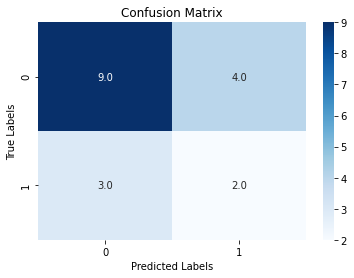

In [42]:
fix, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(df_test_results['observed'], df_test_results['predict'])
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".1f", ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title('Confusion Matrix')
plt.show()

In [43]:
print("Accuracy: ", accuracy_score(df_test_results['observed'], df_test_results['predict']))
print(classification_report(df_test_results['observed'], df_test_results['predict']))

Accuracy:  0.6111111111111112
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.33      0.40      0.36         5

    accuracy                           0.61        18
   macro avg       0.54      0.55      0.54        18
weighted avg       0.63      0.61      0.62        18



In [44]:
# y.sum()

In [45]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy,weights_dict):
    verbose, epochs, batch_size = 0, 10, 16
#     n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 1
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # fit network
#     model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,verbose=verbose)
#     # evaluate model
#     _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, class_weight=weights_dict,verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    return accuracy
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=50):
#     # load data
#     trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    cm_lt=[]
    rdseed_list = []
    for r in range(repeats):
#         rdseed=random.randint(0, 10000)
        rdseed = rdseed_pre_list[r]
        print(rdseed)
        x_train_single, x_test_single, y_train_single, y_test_single = train_test_split(X.astype(np.float), y, test_size=0.2, shuffle=True, random_state=rdseed)

#         mapping = {'CN': 0, 'MCI': 1}
#         y_train_single=pd.DataFrame(y_train_single).replace({0: mapping})[0].values
#         y_test_single=pd.DataFrame(y_test_single).replace({0: mapping})[0].values
        weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train_single), y= y_train_single)
        weights_dict={0: weights[0], 1: weights[1]}
        
        score = evaluate_model(x_train_single, y_train_single, x_test_single, y_test_single,weights_dict)
        score = score * 100.0
        
        y_predict=model.predict(x_test_single)
        df_test_results=pd.concat([pd.DataFrame(y_test_single).rename(columns={0:'observed'}),np.round(pd.DataFrame(y_predict)).rename(columns={0:'predict'})],axis=1)
        cm = confusion_matrix(df_test_results['observed'], df_test_results['predict'])
        
        cm_lt.append(cm)
        print(cm)
        
        rdseed_list.append(rdseed)
        
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    
    print(np.mean(cm_lt,axis=0))
    return(scores,cm_lt,rdseed_list)
# run the experiment
scores,cm_list,rdseed_list = run_experiment()

154
[[12  3]
 [ 0  3]]
>#1: 44.444
9283
[[11  2]
 [ 3  2]]
>#2: 50.000
5843
[[13  2]
 [ 1  2]]
>#3: 77.778
3650
[[8 4]
 [1 5]]
>#4: 38.889
760
[[10  3]
 [ 3  2]]
>#5: 61.111
3704
[[13  2]
 [ 2  1]]
>#6: 77.778
4929
[[15  0]
 [ 0  3]]
>#7: 61.111
2632
[[9 3]
 [0 6]]
>#8: 61.111
1882
[[13  3]
 [ 0  2]]
>#9: 66.667
8268
[[14  2]
 [ 0  2]]
>#10: 72.222
4647
[[14  2]
 [ 1  1]]
>#11: 55.556
6639
[[14  2]
 [ 1  1]]
>#12: 77.778
6775
[[11  4]
 [ 0  3]]
>#13: 50.000
6192


[[12  2]
 [ 0  4]]
>#14: 55.556
9679
[[15  1]
 [ 0  2]]
>#15: 66.667
102
[[12  1]
 [ 1  4]]
>#16: 72.222
3823
[[10  4]
 [ 1  3]]
>#17: 61.111
6577
[[12  2]
 [ 3  1]]
>#18: 66.667
2061
[[11  2]
 [ 2  3]]
>#19: 72.222
3891
[[13  1]
 [ 0  4]]
>#20: 66.667
9310
[[15  0]
 [ 0  3]]
>#21: 55.556
567
[[11  5]
 [ 1  1]]
>#22: 61.111
1948
[[12  3]
 [ 1  2]]
>#23: 44.444
5514
[[10  5]
 [ 2  1]]
>#24: 55.556
6554


[[7 5]
 [3 3]]
>#25: 55.556
6792
[[10  2]
 [ 1  5]]
>#26: 61.111
2080
[[13  1]
 [ 1  3]]
>#27: 72.222
7162
[[13  1]
 [ 1  3]]
>#28: 66.667
7261
[[14  1]
 [ 2  1]]
>#29: 72.222
198
[[14  2]
 [ 0  2]]
>#30: 83.333
6413
[[13  1]
 [ 1  3]]
>#31: 72.222
810
[[11  1]
 [ 1  5]]
>#32: 66.667
4525
[[8 3]
 [2 5]]
>#33: 55.556
9001
[[11  4]
 [ 0  3]]
>#34: 50.000
2197
[[12  3]
 [ 2  1]]
>#35: 55.556
5954


[[10  4]
 [ 1  3]]
>#36: 77.778
5734
[[12  2]
 [ 2  2]]
>#37: 61.111
5386
[[12  2]
 [ 1  3]]
>#38: 66.667
5310
[[13  2]
 [ 1  2]]
>#39: 61.111
8600
[[12  2]
 [ 1  3]]
>#40: 66.667
7889
[[12  1]
 [ 1  4]]
>#41: 61.111
4305
[[12  2]
 [ 2  2]]
>#42: 66.667
2889
[[10  3]
 [ 0  5]]
>#43: 50.000
4029
[[13  4]
 [ 0  1]]
>#44: 66.667
7221
[[9 3]
 [0 6]]
>#45: 72.222
2601
[[12  3]
 [ 1  2]]
>#46: 66.667
4628


[[11  3]
 [ 2  2]]
>#47: 61.111
2503
[[12  2]
 [ 0  4]]
>#48: 44.444
9708
[[13  1]
 [ 2  2]]
>#49: 77.778
557
[[11  4]
 [ 1  2]]
>#50: 66.667
[44.44444477558136, 50.0, 77.77777910232544, 38.88888955116272, 61.11111044883728, 77.77777910232544, 61.11111044883728, 61.11111044883728, 66.66666865348816, 72.22222089767456, 55.55555820465088, 77.77777910232544, 50.0, 55.55555820465088, 66.66666865348816, 72.22222089767456, 61.11111044883728, 66.66666865348816, 72.22222089767456, 66.66666865348816, 55.55555820465088, 61.11111044883728, 44.44444477558136, 55.55555820465088, 55.55555820465088, 61.11111044883728, 72.22222089767456, 66.66666865348816, 72.22222089767456, 83.33333134651184, 72.22222089767456, 66.66666865348816, 55.55555820465088, 50.0, 55.55555820465088, 77.77777910232544, 61.11111044883728, 66.66666865348816, 61.11111044883728, 66.66666865348816, 61.11111044883728, 66.66666865348816, 50.0, 66.66666865348816, 72.22222089767456, 66.66666865348816, 61.11111044883728, 44.4444447755813

In [46]:
# # cm_lt
cm_list_fullmri_RNN_1d=[]
# cm_list_fullmri_RNN_1d_pre=[]

for  i in range(len(cm_list)):
    cm_list_fullmri_RNN_1d.append(cm_list[i].reshape(1,4)[0])
#     cm_list_fullmri_RNN_1d_pre.append(cm_list_pre[i].reshape(1,4)[0])

In [47]:
# rdseed_pre_list = rdseed_list
# acc_list_pre=scores
# cm_list_pre=cm_list

In [48]:
# pd.concat([pd.DataFrame(rdseed_pre_list,columns=['rdseed_pre_list']),pd.DataFrame(cm_list_fullmri_RNN_1d),pd.DataFrame(scores,columns=['acc_list']),pd.DataFrame(cm_list_fullmri_RNN_1d_pre),pd.DataFrame(acc_list_pre,columns=['acc_list_pre'])],axis=1)

In [49]:
pd.DataFrame(cm_list_fullmri_RNN_1d).mean()
# pd.DataFrame(cm_list_fullmri_RNN_1d).to_csv('cm_list_fullmri_RNN_1d_1.csv')

0    11.80
1     2.40
2     1.04
3     2.76
dtype: float64

In [50]:
# rdseed_list

In [51]:
np.mean(scores)
# np.mean(acc_list_pre)

63.00000065565109

In [52]:
# rdseed_pre_list

In [53]:
# plt.hist(acc_list_pre)

(array([ 1.,  3.,  4.,  7.,  0., 10., 12.,  7.,  5.,  1.]),
 array([38.88888955, 43.33333373, 47.77777791, 52.22222209, 56.66666627,
        61.11111045, 65.55555463, 69.99999881, 74.44444299, 78.88888717,
        83.33333135]),
 <BarContainer object of 10 artists>)

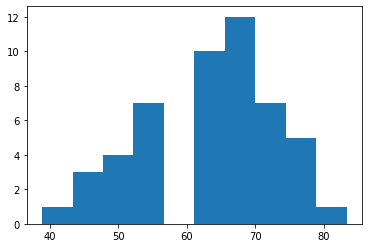

In [54]:
plt.hist(scores)